# NOTES

# IMPORT

In [23]:
# Architecture
from keras import models
from keras import layers
from keras import backend as K
from keras.utils import plot_model

# Dataset
import os
import cv2
import imutils
import numpy as np
from imutils import paths
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array

# Plotting
import matplotlib.pyplot as plt

# Evaluation
from sklearn.metrics import classification_report

# HELPER

# DATASET

## Variables

In [3]:
data = []
labels = []

# Directories
dataset = 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Case Studi/smileDetector/dataset/'
neg_data = os.path.join(dataset, 'negatives/')
pos_data = os.path.join(dataset, 'positives/')

# Image Paths
neg_data_paths = list(paths.list_images(neg_data))
pos_data_paths = list(paths.list_images(pos_data))
data_paths = neg_data_paths

# Combine paths in one list
for (i, path) in enumerate(pos_data_paths):
    data_paths.append(path)
    
data_paths = shuffle(data_paths)

## Data and labels extraction

In [4]:
print('[INFO] data reading and preprocesing...')
verbose = 500
for (i, path) in enumerate(data_paths):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = imutils.resize(image, width=28)
    image = img_to_array(image)
    data.append(image)
    
    
    # Labels
    img_dir_tuple = os.path.split(path)
    dir_tuple = os.path.split(img_dir_tuple[0])
    label = dir_tuple[-1]
    label = 'smiling' if label == 'positives' else 'not smiling'
    labels.append(label)
    

    if i > 0  and verbose > 0 and (i + 1) % verbose == 0:
        print('[INFO] processed {}/{}'.format((i + 1), len(data_paths)))

[INFO] data reading and preprocesing...
[INFO] processed 500/13165
[INFO] processed 1000/13165
[INFO] processed 1500/13165
[INFO] processed 2000/13165
[INFO] processed 2500/13165
[INFO] processed 3000/13165
[INFO] processed 3500/13165
[INFO] processed 4000/13165
[INFO] processed 4500/13165
[INFO] processed 5000/13165
[INFO] processed 5500/13165
[INFO] processed 6000/13165
[INFO] processed 6500/13165
[INFO] processed 7000/13165
[INFO] processed 7500/13165
[INFO] processed 8000/13165
[INFO] processed 8500/13165
[INFO] processed 9000/13165
[INFO] processed 9500/13165
[INFO] processed 10000/13165
[INFO] processed 10500/13165
[INFO] processed 11000/13165
[INFO] processed 11500/13165
[INFO] processed 12000/13165
[INFO] processed 12500/13165
[INFO] processed 13000/13165


## Data scalling and label binarization

In [5]:
# Scaling
data = np.array(data, dtype='float') / 255.0
labels = np.array(labels)

# # Binarization
# lb = LabelBinarizer()
# labels = lb.fit_transform(labels)
# labels

# Encoding
le = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(le.transform(labels), 2)
labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

## Handling Data Imbalance

In [6]:
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

print('[INFO] not smiling: ', classTotals[0])
print('[INFO] smiling: ', classTotals[1])
print('[INFO] {} of not smiling will represent {} of smiling samples'.format(classWeight[0], classWeight[1]))

[INFO] not smiling:  9475.0
[INFO] smiling:  3690.0
[INFO] 1.0 of not smiling will represent 2.5677506923675537 of smiling samples


## Data separation

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
testX.shape

(2633, 28, 28, 1)

# ARCHITECTURE

## Variables

In [8]:
width = 28
height = 28
channels = 1
classes = 2
input_shape = (width, height, channels)

if K.image_data_format() == 'channels_first':
    input_shape = (channels, width, height)



## Architecture Definition

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(20, (5, 5), padding='same', input_shape=input_shape))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (5, 5), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(500))
model.add(layers.Activation('relu'))
model.add(layers.Dense(classes))
model.add(layers.Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2450)             

## Serialize Architecture

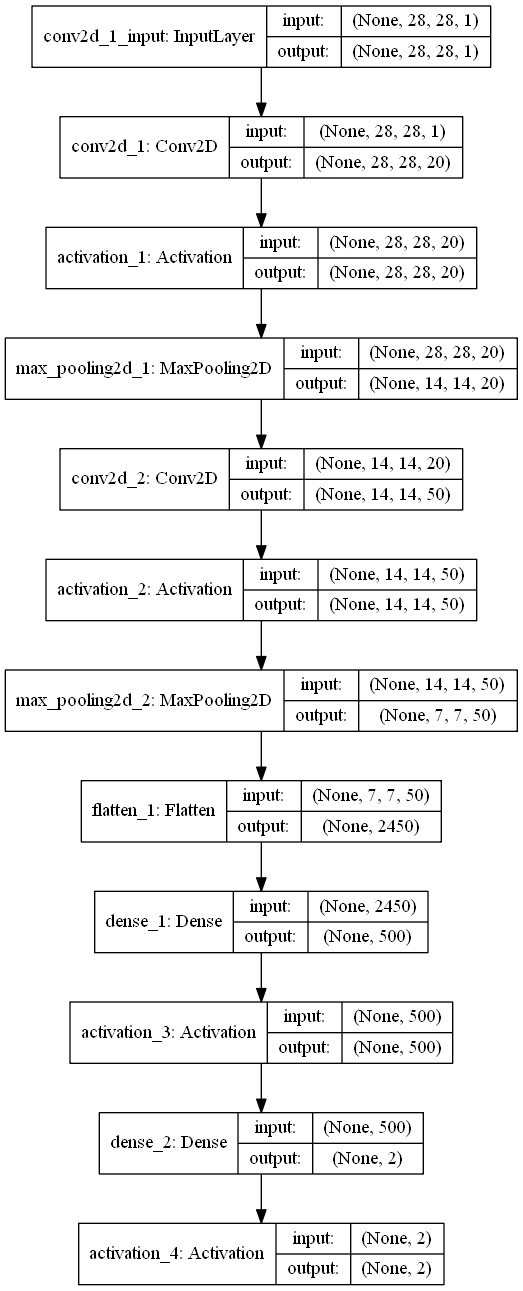

In [10]:
plot_model(model, to_file='serialized/LeNet_Architecture.png', show_shapes=True)

# COMPILATION

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# TRAINING

In [12]:
history = model.fit(trainX, trainY, epochs=15, batch_size=64, validation_data=(testX, testY), verbose=1, class_weight=classWeight)

Train on 10532 samples, validate on 2633 samples
Epoch 1/15
10532/10532 [==============================] - 12s 1ms/step - loss: 0.4122 - acc: 0.8111 - val_loss: 0.3073 - val_acc: 0.8709
Epoch 2/15
10532/10532 [==============================] - 4s 401us/step - loss: 0.2761 - acc: 0.8902 - val_loss: 0.2811 - val_acc: 0.8792
Epoch 3/15
10532/10532 [==============================] - 4s 395us/step - loss: 0.2445 - acc: 0.9030 - val_loss: 0.2707 - val_acc: 0.8872
Epoch 4/15
10532/10532 [==============================] - 4s 397us/step - loss: 0.2293 - acc: 0.9098 - val_loss: 0.2624 - val_acc: 0.8986
Epoch 5/15
10532/10532 [==============================] - 7s 681us/step - loss: 0.2187 - acc: 0.9162 - val_loss: 0.2496 - val_acc: 0.9001
Epoch 6/15
10532/10532 [==============================] - 4s 397us/step - loss: 0.2060 - acc: 0.9220 - val_loss: 0.2511 - val_acc: 0.8978
Epoch 7/15
10532/10532 [==============================] - 4s 396us/step - loss: 0.1941 - acc: 0.9258 - val_loss: 0.2368 - va

# PLOTTING

## Variables

In [17]:
history_dict = history.history
epochs = np.arange(0, 15)

accuracy = history_dict['acc']
val_accuracy = history_dict['val_acc']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

## Accuracy

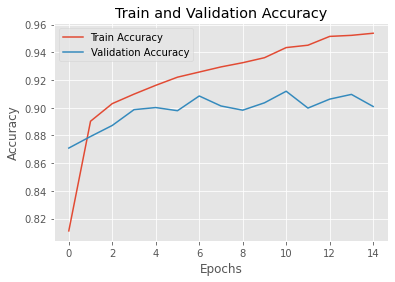

In [20]:
plt.style.use('ggplot')
plt.plot(epochs, accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Loss

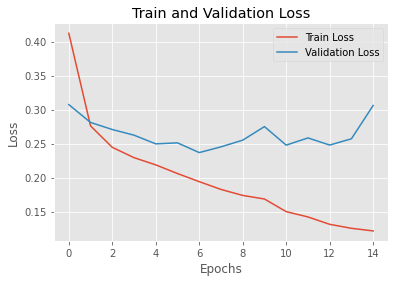

In [21]:
plt.clf()
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# EVALUATION

In [26]:
results = model.evaluate(testX, testY)
print('[INFO] the overall accuracy is {}'.format(results[1]))

2633/2633 [==============================] - 0s 153us/step
[INFO] the overall accuracy is 0.9008735418319702


# PREDICTION

In [28]:
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=le.classes_))

              precision    recall  f1-score   support

 not smiling       0.90      0.97      0.93      1895
     smiling       0.90      0.73      0.80       738

    accuracy                           0.90      2633
   macro avg       0.90      0.85      0.87      2633
weighted avg       0.90      0.90      0.90      2633



# SERIALIZATION

In [29]:
model.save('serialized/LeNet.hdf5')